## Notebook for project in course: HPC4WC
created by: Andrea Leuthard, Ida Olsen and Manuel Brülisauer 

In [1]:
import timeit
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def read_field_from_file(filename, num_halo=None):
    (rank, nbits, num_halo, nx, ny, nz) = np.fromfile(filename, dtype=np.int32, count=6)
    offset = (3 + rank) * 32 // nbits
    data = np.fromfile(
        filename,
        dtype=np.float32 if nbits == 32 else np.float64,
        count=nz * ny * nx + offset,
    )
    if rank == 3:
        return np.reshape(data[offset:], (nz, ny, nx))
    else:
        return np.reshape(data[offset:], (ny, nx))


def validate_results(outfile, outfile_filt):
    fig, axs = plt.subplots(1, 4, figsize=(20, 6))

    in_field = read_field_from_file("in_field.dat")
    im1 = axs[0].imshow(
        in_field[in_field.shape[0] // 2, :, :], origin="lower", vmin=-0.2, vmax=1.2
    )
    fig.colorbar(im1, ax=axs[0])
    axs[0].set_title("initial condition")

    out_field = read_field_from_file(outfile)
    im2 = axs[1].imshow(
        out_field[out_field.shape[0] // 2, :, :], origin="lower", vmin=-0.2, vmax=1.2
    )
    fig.colorbar(im2, ax=axs[1])
    axs[1].set_title("final result")
    
    
    # read filtered output
    out_field_filt = read_field_from_file(outfile_filt)
    im3 = axs[2].imshow(
    out_field_filt[out_field_filt.shape[0] // 2, :, :], origin="lower", vmin=-0.2, vmax=1.2
    )
    fig.colorbar(im3, ax=axs[2])
    axs[2].set_title("final result filtered")
    
    
    im4 = axs[3].plot(out_field[out_field.shape[0] // 2, :, out_field.shape[2] // 2], label = 'unfiltered')
    im5 = axs[3].plot(out_field_filt[out_field_filt.shape[0] // 2, :, out_field_filt.shape[2] // 2], label = 'filtered')
    axs[3].set_title("horizontal view")
    axs[3].grid()
    axs[3].legend()

    plt.savefig("output.png", bbox_inches='tight')
    plt.show()


### Compile files

In [3]:
%%bash

module load daint-gpu
module load perftools-lite

CC stencil2d-pro.cpp -fopenmp -o stencil2d-pro.x -O3
# CC zalesak_version2.cpp -fopenmp -o zalesak_version2.x -O3

INFO: creating the PerfTools-instrumented executable 'stencil2d-pro.x' (lite-samples) ...OK


### Run file

In [5]:
%%bash
srun -n 1 ./stencil2d-pro.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024 --order 4

6.8295,4.77273



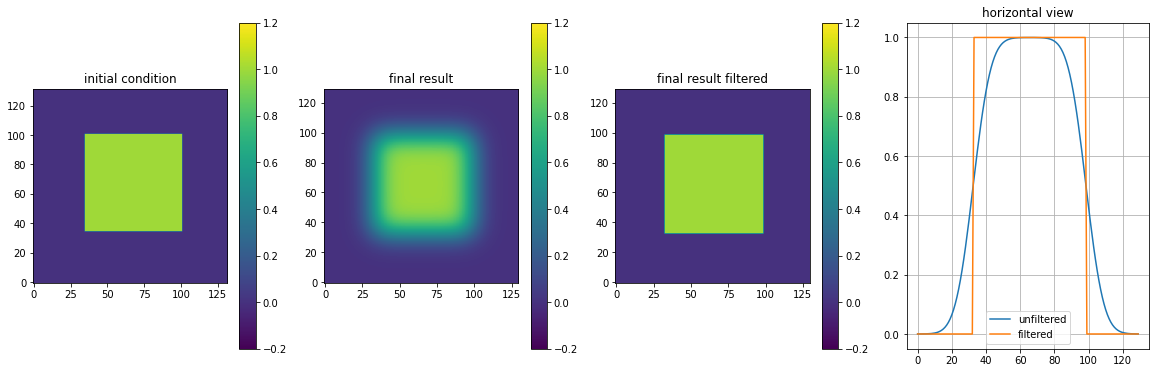

In [6]:
validate_results("out_field.dat", "out_field_filtered.dat")

/tmp/ipykernel_18566/1225911408.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='both')


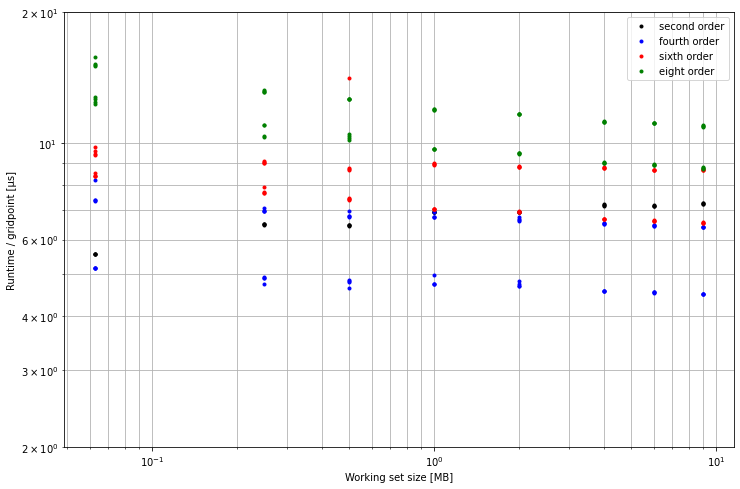

In [7]:
## Plot output from scanning.ipynb
size = np.array(np.load("size.npy"))
output2 = np.array(np.load("output2.npy"))
output4 = np.array(np.load("output4.npy"))
output6 = np.array(np.load("output6.npy"))
output8 = np.array(np.load("output8.npy"))

plt.figure(figsize=(14, 4))
plt.loglog( size * 4 / 1024. / 1024., output2/size *10**6, '.', color = 'k', label= 'second order');
plt.loglog( size * 4 / 1024. / 1024., output4/size *10**6, '.', color = 'b', label= 'fourth order');
plt.loglog( size * 4 / 1024. / 1024., output6/size *10**6, '.', color = 'r', label= 'sixth order');
plt.loglog( size * 4 / 1024. / 1024., output8/size *10**6, '.', color = 'g', label= 'eight order');
plt.xlabel( 'Working set size [MB]' );
plt.ylabel( 'Runtime / gridpoint [µs]' );
plt.legend()
plt.grid(b=True, which='both')
plt.ylim(2, 20)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 8)

plt.savefig("cache_performance.png", bbox_inches='tight')
plt.show()

In [8]:
## Make plot for report
def validate_report():
    fig, axs = plt.subplots(1, 4, figsize=(16, 5))
    
    out_field = read_field_from_file("out_field2.dat")
    im4 = axs[0].plot(out_field[out_field.shape[0] // 2, :, out_field.shape[2] // 2])
    #axs[0].legend(loc="center")
    axs[0].set_title("horizontal view, n = 2")
    axs[0].grid()

    out_field = read_field_from_file("out_field4.dat")
    out_field_filt = read_field_from_file("out_field_filtered4.dat")
    im4 = axs[1].plot(out_field[out_field.shape[0] // 2, :, out_field.shape[2] // 2])
    im4 = axs[1].plot(out_field_filt[out_field_filt.shape[0] // 2, :, out_field_filt.shape[2] // 2])
    #axs[1].legend(loc="center")
    axs[1].set_title("horizontal view, n = 4")
    axs[1].grid()

    out_field = read_field_from_file("out_field6.dat")
    out_field_filt = read_field_from_file("out_field_filtered6.dat")
    im4 = axs[2].plot(out_field[out_field.shape[0] // 2, :, out_field.shape[2] // 2])
    im4 = axs[2].plot(out_field_filt[out_field_filt.shape[0] // 2, :, out_field_filt.shape[2] // 2])
    #axs[2].legend(loc="center")
    axs[2].set_title("horizontal view, n = 6")
    axs[2].grid()
    
    out_field = read_field_from_file("out_field8.dat")
    out_field_filt = read_field_from_file("out_field_filtered8.dat")
    im4 = axs[3].plot(out_field[out_field.shape[0] // 2, :, out_field.shape[2] // 2])
    im4 = axs[3].plot(out_field_filt[out_field_filt.shape[0] // 2, :, out_field_filt.shape[2] // 2])
    #axs[3].legend(loc="center")
    axs[3].set_title("horizontal view, n = 8")
    axs[3].grid()

    plt.savefig("comparison.png", bbox_inches='tight')
    plt.show()

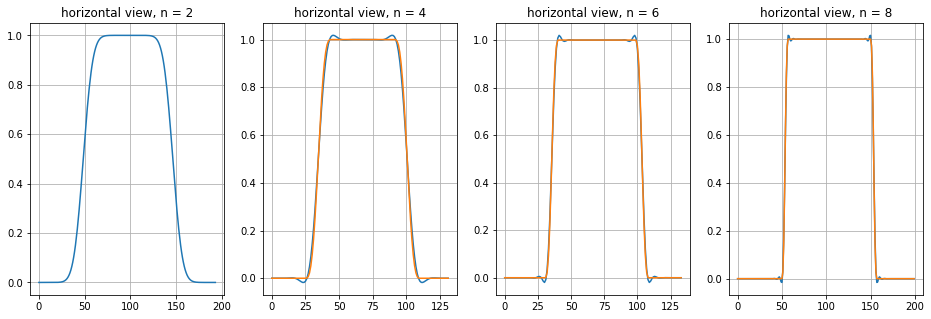

In [9]:
validate_report()